In [8]:
# Import libs utilizadas

import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import recall_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTENC
import warnings
warnings.filterwarnings("ignore")
import time

## Carga do Dataset

In [9]:
# O dataset utilizado contém informações sobre clientes bancários, dentre elas o dado de churn, se o cliente saiu do banco ou não
# Url de importação do datset do Kaggle
# Fonte original: https://www.kaggle.com/datasets/saurabhbadole/bank-customer-churn-prediction-dataset?select=Churn_Modelling.csv

# Caminho do dataset
caminho_dataset = '../data/churn_modelling.csv'

# Leitura do arquivo dataset
dataset = pd.read_csv(caminho_dataset, delimiter= ',')

# Imprime a quantidade de linhas antes de remover amostra aleatoria
print(f"Quantidade de linhas: {dataset.shape[0]}")
print(f"Quantidade de colunas: {dataset.shape[1]}")

Quantidade de linhas: 10000
Quantidade de colunas: 14


In [10]:
# Mostra as primeiras linhas do dataset
dataset.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [11]:
# Remove colunas desnecessárias, que não serão utilizadas no treinamento do modelo
dataset = dataset.drop(columns=['RowNumber', 'CustomerId', 'Surname'])

# Mostra as primeiras linhas do dataset após a eliminação das colunas desnecessárias
dataset.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [12]:
# Remove uma amostra de 10 linhas de forma aleatória e balanceada para ser usada para fins de teste na aplicação. Esses dados serão usados no final desse notebook
# Selecionar 5 linhas onde 'exited' é 0
amostra_aleatoria_1 = dataset[dataset['Exited'] == 0].sample(n=5, random_state=7)

# Selecionar 5 linhas onde 'exited' é 1
amostra_aleatoria_2 = dataset[dataset['Exited'] == 1].sample(n=5, random_state=7)

# Combinar as duas amostras
amostra_aleatoria_balanceada = pd.concat([amostra_aleatoria_1, amostra_aleatoria_2])

# Amostra aleatória - variável target
amostra_aleatoria_y = amostra_aleatoria_balanceada['Exited']

# Amostra aleatória - Define as variáveis preditoras (todas as colunas exceto 'Exited')
amostra_aleatoria_x = amostra_aleatoria_balanceada.drop(columns=['Exited'])

# Remover a amostra aleatória do dataframe original
dataset_sem_amostra_aleatoria = dataset.drop(amostra_aleatoria_balanceada.index)

# Imprime a quantidade de linhas depois de remover amostra aleatoria
print(f"Quantidade de linhas: {dataset_sem_amostra_aleatoria.shape[0]}")
print(f"Quantidade de colunas: {dataset_sem_amostra_aleatoria.shape[1]}")


Quantidade de linhas: 9990
Quantidade de colunas: 11


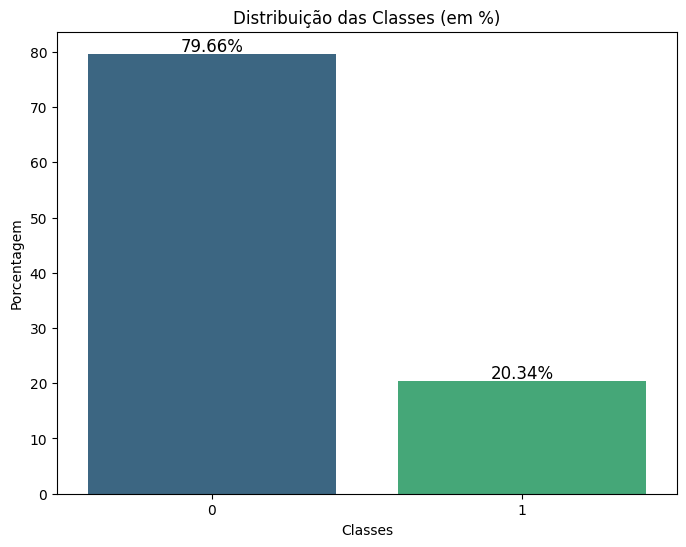

In [13]:
# Avaliando o balanceamento dos dados
# Calcula as porcentagens
class_counts = dataset_sem_amostra_aleatoria['Exited'].value_counts(normalize=True) * 100

# Criando o gráfico de barras com as porcentagens
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, hue=class_counts.index, palette='viridis', legend=False)

# Adicionando rótulos com as porcentagens no topo de cada barra
for i, value in enumerate(class_counts.values):
    plt.text(i, value + 0.5, f'{value:.2f}%', ha='center', fontsize=12)

plt.title('Distribuição das Classes (em %)')
plt.ylabel('Porcentagem')
plt.xlabel('Classes')
plt.show()

## Separação em conjunto de treino e conjunto de teste com holdout

In [14]:
test_size = 0.2 # tamanho do conjunto de teste
seed = 7 # semente aleatória. Sempre que houver uma operação que dependa de aleatoriedade (como a divisão entre treino e teste), o resultado seja sempre o mesmo ao rodar o script (garante a reprodutibilidade do notebook).
# Define a variável alvo (coluna 'Exited')

y = dataset_sem_amostra_aleatoria['Exited']

# Define as variáveis preditoras (todas as colunas exceto 'Exited')
x = dataset_sem_amostra_aleatoria.drop(columns=['Exited'])

# Separação em conjuntos de treino (80%) e teste (20%) com os dados transformados
x_train, x_test, y_train, y_test = train_test_split(x, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação, garantindo proporção de variável alvo nos conjuntos

# Parâmetros e partições da validação cruzada
scoring = 'recall' # proporção de todos os positivos reais que foram classificados corretamente como positivos. Mais adequado visto que os falsos negativos tem um alto custo (ou seja, clientes que churnam e não são identificados corretamente pelo modelo tem um alto valor para o negócio).
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação

Dado o desbalanceamento do dataset, optou-se pela utilização do SMOTENC, uma técnica de oversampling, que sintetiza a criação de novos dados.

O SMOTENC é uma variação do SMOTE que consegue lidar com colunas categóricas.

In [15]:
# nomes das colunas categóricas
categorical_features = ['Gender', 'Geography']

# Obtenha os índices das colunas categóricas
categorical_indices = [x.columns.get_loc(col) for col in categorical_features]

# Aplica SMOTE (ténica de oversampling) para balancear o conjunto de treino
smote_nc = SMOTENC(categorical_features=categorical_indices, random_state=seed)
x_train_resampled, y_train_resampled = smote_nc.fit_resample(x_train, y_train)

# Verifica a distribuição das classes após o SMOTE
print(f"Distribuição original das classes no conjunto de treino:\n{pd.Series(y_train).value_counts()}")
print(f"Distribuição das classes após o SMOTE:\n{pd.Series(y_train_resampled).value_counts()}")

Distribuição original das classes no conjunto de treino:
Exited
0    6366
1    1626
Name: count, dtype: int64
Distribuição das classes após o SMOTE:
Exited
0    6366
1    6366
Name: count, dtype: int64


## Modelagem e Inferência

### Criação e avaliação de modelos: dados padronizados e normalizados

RF-orig: 0.860 (0.015)
KNN-orig: 0.768 (0.026)
CART-orig: 0.809 (0.018)
NB-orig: 0.756 (0.010)
SVM-orig: 0.747 (0.016)
RF-padr: 0.861 (0.014)
KNN-padr: 0.836 (0.015)
CART-padr: 0.809 (0.018)
NB-padr: 0.762 (0.012)
SVM-padr: 0.827 (0.018)
RF-norm: 0.861 (0.015)
KNN-norm: 0.819 (0.019)
CART-norm: 0.808 (0.018)
NB-norm: 0.762 (0.012)
SVM-norm: 0.798 (0.015)


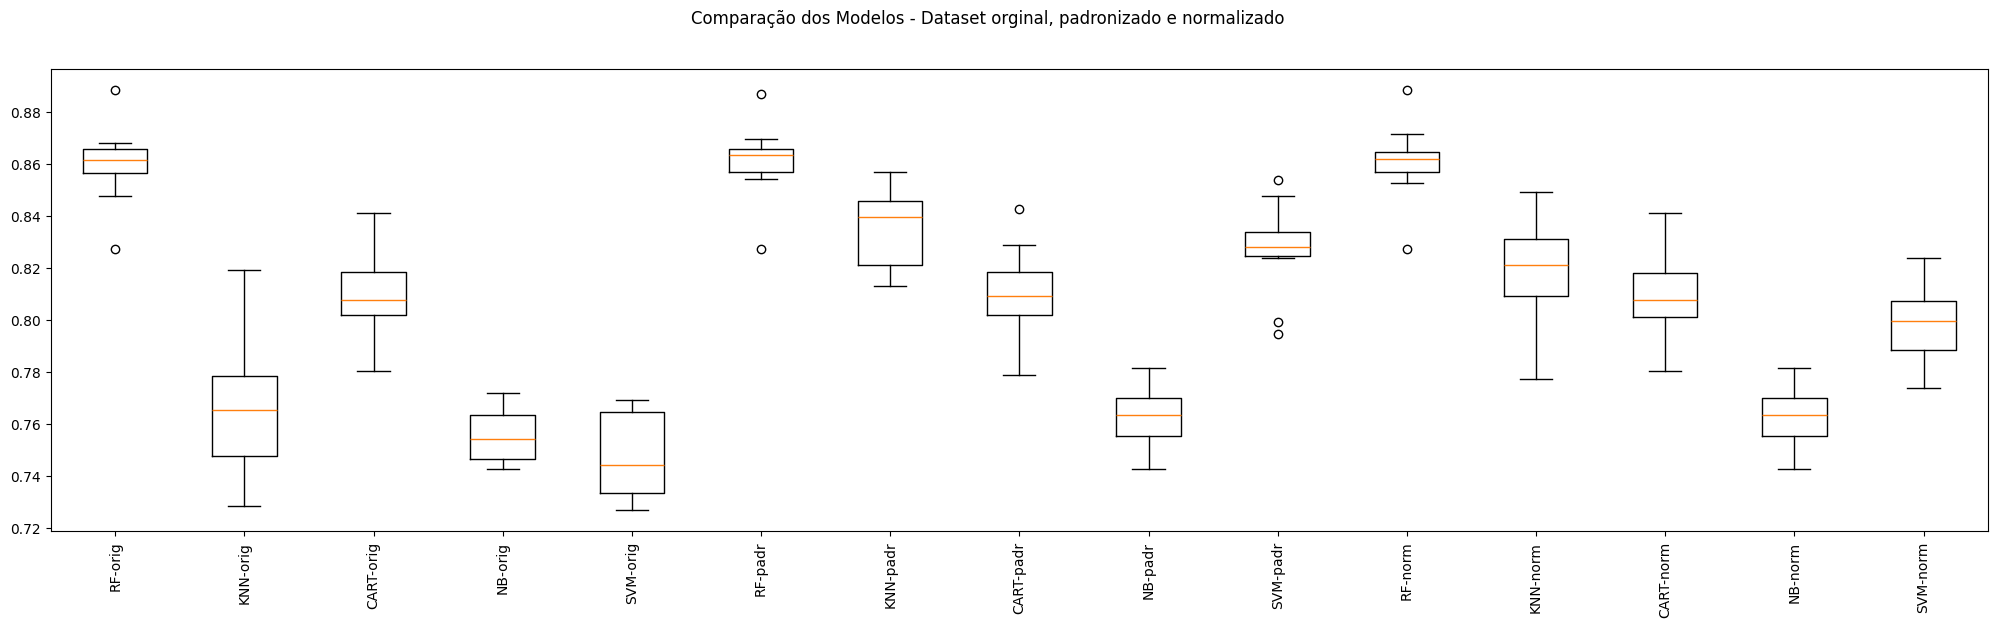

In [16]:
# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []

# Criando os elementos do pipeline
# Algoritmos que serão utilizados
rf = ('RF', RandomForestClassifier(random_state=seed))
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier(random_state=seed))
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC(random_state=seed))

# Transformações que serão utilizadas
# Padroniza os dados para ter média 0 e desvio padrão 1
standard_scaler = ('StandardScaler', StandardScaler())
# Normaliza os dados para que fiquem entre 0 e 1.
min_max_scaler = ('MinMaxScaler', MinMaxScaler())
# Faz o pre processamento das colunas categóricas
onehot_encoder = OneHotEncoder(drop='first',handle_unknown='ignore')
preprocessor = ColumnTransformer(
     transformers=[('cat', onehot_encoder, categorical_features)],
     remainder='passthrough'
)
encoder=('encoder',preprocessor)


# Montando os pipelines
"""
Um pipeline é composta por uma sequência de passos, onde cada passo pode ser uma transformação de dados ou um algoritmo de aprendizado de máquina.
O pipeline processa os dados de entrada sequencialmente, aplicando cada transformação em ordem e, ao final, ajusta o modelo nos dados transformados.
"""

# Dataset original
pipelines.append(('RF-orig', Pipeline(steps=[encoder,rf])))
pipelines.append(('KNN-orig', Pipeline(steps=[encoder, knn])))
pipelines.append(('CART-orig', Pipeline(steps=[encoder, cart])))
pipelines.append(('NB-orig', Pipeline(steps=[encoder, naive_bayes])))
pipelines.append(('SVM-orig', Pipeline(steps=[encoder, svm])))

# Dataset Padronizado
pipelines.append(('RF-padr', Pipeline(steps=[encoder, standard_scaler, rf])))
pipelines.append(('KNN-padr', Pipeline(steps=[encoder, standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline(steps=[encoder, standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline(steps=[encoder, standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline(steps=[encoder, standard_scaler, svm])))

# Dataset Normalizado
pipelines.append(('RF-norm', Pipeline(steps=[encoder, min_max_scaler, rf])))
pipelines.append(('KNN-norm', Pipeline(steps=[encoder, min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline(steps=[encoder, min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline(steps=[encoder, min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline(steps=[encoder, min_max_scaler, svm])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, x_train_resampled, y_train_resampled, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

O algoritmo Random Forest foi o que obteve a melhor métrica de scoring comparada com aos outros algoritmos.

### Otimização dos hiperparâmetros

In [44]:
#Tuning do RF

pipelines = []

# Definindo os componentes do pipeline
rf = ('RF', RandomForestClassifier(random_state=seed))

pipelines.append(('rf-orig', Pipeline(steps=[encoder,standard_scaler,rf])))

param_grid = {
    'RF__n_estimators': [10, 50, 100],
    'RF__max_features': ['sqrt', 'log2'],
    'RF__max_depth': [None, 10, 20, 30],
    'RF__min_samples_split': [2, 5, 10],
    'RF__min_samples_leaf': [1, 2, 4]
}

# Prepara e executa o GridSearchCV
for name, model in pipelines:
    start_time = time.time()  # Começar o contador
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold, verbose=2)
    grid.fit(x_train_resampled,y_train_resampled)
    # imprime a melhor configuração
    print("%s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

    # Calcular e exibir o tempo gasto
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    # imprime a melhor configuração
    print(f"{name} - Melhor: {grid.best_score_:.4f} usando {grid.best_params_}")
    print(f"Tempo gasto: {elapsed_time:.2f} segundos")

Fitting 10 folds for each of 216 candidates, totalling 2160 fits
[CV] END RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=2, RF__n_estimators=10; total time=   0.2s
[CV] END RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=2, RF__n_estimators=10; total time=   0.2s
[CV] END RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=2, RF__n_estimators=10; total time=   0.2s
[CV] END RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=2, RF__n_estimators=10; total time=   0.2s
[CV] END RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=2, RF__n_estimators=10; total time=   0.2s
[CV] END RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=2, RF__n_estimators=10; total time=   0.2s
[CV] END RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_sampl

## Finalização do modelo

A otimização utilizando hiperparâmetros levou a uma melhor métrica de scoring, seguiu-se com os parâmetros de melhor desempenho

In [17]:
model = ('RF_final',RandomForestClassifier(random_state=seed,max_depth=20, max_features='sqrt',min_samples_leaf=1, min_samples_split=2,n_estimators=100))

# Pipeline final
pipeline = Pipeline(steps=[encoder,standard_scaler,model])
pipeline.fit(x_train_resampled, y_train_resampled)

# Estimativa da acurácia no conjunto de teste
predictions = pipeline.predict(x_test)
print("Recall no conjunto de teste: ", recall_score(y_test, predictions))

Recall no conjunto de teste:  0.6625615763546798


O scoring de recall do modelo no conjunto de teste obteve um valor menor do que o conjunto de treino. Essa observação pode ser um indício de que houve overfitting do modelo aos dados de treino, já que não foi possível generalizar o modelo apra os dados de teste.

É recomendado uma etapa de coleta e rotulação dos dados para obter um volume de dados mais equilibrado de classes, já que a utilização de dados sintéticos (oversampling) pode ter influencido os resultados

In [18]:
# Preparação do modelo com TODO o dataset
pipeline.fit(x, y)

Pipeline(steps=[('encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['Gender', 'Geography'])])),
                ('StandardScaler', StandardScaler()),
                ('RF_final',
                 RandomForestClassifier(max_depth=20, random_state=7))])

## Salvando arquivos

In [47]:
# Salvando o pipeline de melhor algoritmo em um arquivo .pkl
with open('../models/churn_modelling_pipeline_rf.pkl', 'wb') as file:
    pickle.dump(pipeline, file)

# Salvando a amostar de dados aleatórias separada inicialmente para fins de teste
colunas_x = ['CreditScore','Geography','Gender','Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
x_test_df = pd.DataFrame(amostra_aleatoria_x, columns= colunas_x)
colunas_y = ['Exited']
y_test_df = pd.DataFrame(amostra_aleatoria_y, columns= colunas_y)
x_test_df.to_csv("../data/x_test_dataset_churning.csv", index=False)
y_test_df.to_csv("../data/y_test_dataset_churning.csv", index=False)